<a href="https://colab.research.google.com/github/hudanurengin/Cure-the-princess/blob/main/Cure_The_Princess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader




In [209]:
"""def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device"""

In [210]:
"""DEVICE = set_device()"""

In [235]:

torch.manual_seed(180401051)

In [212]:
uploaded = files.upload()

Saving cure_the_princess_test.csv to cure_the_princess_test (5).csv
Saving cure_the_princess_train.csv to cure_the_princess_train (5).csv
Saving cure_the_princess_validation.csv to cure_the_princess_validation (5).csv


In [236]:
train_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_train.csv']))
train_labels = train_data.iloc[:, -1]
train_data = train_data.iloc[:, :-1]

val_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_validation.csv']))
val_labels = val_data.iloc[:, -1]
val_data = val_data.iloc[:, :-1] 

test_data = pd.read_csv(io.BytesIO(uploaded['cure_the_princess_test.csv']))
test_labels = test_data.iloc[:, -1]
test_data = test_data.iloc[:, :-1]

In [237]:
# Örnek bir dataset sınıfı oluşturalım
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data.values)
        self.labels = torch.Tensor(labels.values.reshape(-1, 1))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [238]:
# Data loader'ları tanımlayalım
batch_size = 32
train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)
test_dataset = MyDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [239]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [248]:
# Modelimizi tanımlayalım
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
learning_rate = 0.001
epochs = 100

model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Epoch: 10/100, Train Loss: 0.4523, Val Loss: 0.4111
Epoch: 20/100, Train Loss: 0.3669, Val Loss: 0.3053
Epoch: 30/100, Train Loss: 0.3251, Val Loss: 0.2770
Epoch: 40/100, Train Loss: 0.2954, Val Loss: 0.2411
Epoch: 50/100, Train Loss: 0.2804, Val Loss: 0.2354
Epoch: 60/100, Train Loss: 0.2636, Val Loss: 0.2241
Epoch: 70/100, Train Loss: 0.2521, Val Loss: 0.2127
Epoch: 80/100, Train Loss: 0.2369, Val Loss: 0.2090
Epoch: 90/100, Train Loss: 0.2303, Val Loss: 0.2044
Epoch: 100/100, Train Loss: 0.2216, Val Loss: 0.1989


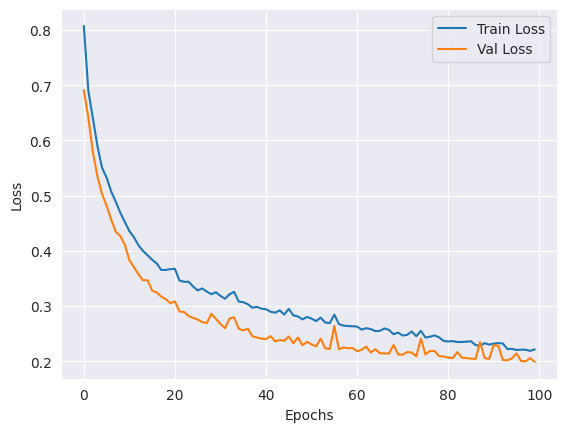

In [249]:
#def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs):
train_losses = []
val_losses = []
best_model = None
best_val_loss= float('inf')
patience_counter = 0
for epoch in range(epochs):
        # Training
    model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

        # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


sns.set_style("darkgrid")
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs)

In [251]:
tp = 0  # True positives
fp = 0  # False positives
tn = 0  # True negatives
fn = 0  # False negatives
model.eval()
with torch.no_grad():
      for i, (inputs, labels) in enumerate(val_dataloader):
              outputs = model(inputs.float())
              loss = criterion(outputs, labels)
              val_loss += loss.item()
val_loss /= len(val_dataloader)
val_losses.append(val_loss)
predicted_labels = (outputs >= 0.5).float()

# matrisi güncelliyorum
tp += torch.sum(predicted_labels * labels).item()
fp += torch.sum(predicted_labels * (1 - labels)).item()
tn += torch.sum((1 - predicted_labels) * (1 - labels)).item()
fn += torch.sum((1 - predicted_labels) * labels).item()

# accuracy, precision, recall and F1 score
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f'Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}')

Test Accuracy: 0.8846, Test Precision: 0.9286, Test Recall: 0.8667, Test F1: 0.8966
